### Impot libraries

In [1]:
import pandas as pd
import torch
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, models
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights
import torch.optim as optim

### Reading data

In [2]:
import kagglehub

path = kagglehub.dataset_download("astraszab/facial-expression-dataset-image-folders-fer2013")

print("Path to dataset files:", path)

/home/alisadmitr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/alisadmitr/.cache/kagglehub/datasets/astraszab/facial-expression-dataset-image-folders-fer2013/versions/1


In [3]:
data_dir = os.path.join(path, 'data')
if os.path.exists(data_dir):
    for root, dirs, files in os.walk(data_dir):
        print(f"In '{root}':")
        print("Directories:", dirs)
        print("Files:", files)
        break
else:
    print("Подкаталог 'data' не найден.")


In '/home/alisadmitr/.cache/kagglehub/datasets/astraszab/facial-expression-dataset-image-folders-fer2013/versions/1/data':
Directories: ['train', 'test', 'val']
Files: []


In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir=None, folder=None, transform=None, images=None, labels=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        if images is not None and labels is not None:
            self.image_paths = images
            self.labels = np.array(labels)
        else:
            folder_dir = os.path.join(data_dir, folder)
            for class_folder in os.listdir(folder_dir):
                class_path = os.path.join(folder_dir, class_folder)
                if os.path.isdir(class_path): 
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"): 
                            path = os.path.join(class_path, filename)
                            if os.path.isfile(path):
                                self.image_paths.append(path)
                                self.labels.append(int(class_folder))
            self.labels = np.array(self.labels)
            
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_paths[idx]
        
        if isinstance(image, str): 
            image = Image.open(image).convert('RGB')
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label).long()

In [5]:
train_dataset = ImageDataset(data_dir, folder='train', transform=None)
val_dataset = ImageDataset(data_dir, folder='val', transform=None)
test_dataset = ImageDataset(data_dir, folder='test', transform=None)

In [6]:
unique_train_labels = np.unique(train_dataset.labels)
unique_val_labels = np.unique(val_dataset.labels)
unique_test_labels = np.unique(test_dataset.labels)

print("Unique train labels:", unique_train_labels)
print("train size:", len(train_dataset))
print("Unique validation labels:", unique_val_labels)
print("val size:", len(val_dataset))
print("Unique test labels:", unique_test_labels)
print("test size:", len(test_dataset))

Unique train labels: [0 1 2 3 4 5 6]
train size: 28709
Unique validation labels: [0 1 2 3 4 5 6]
val size: 3589
Unique test labels: [0 1 2 3 4 5 6]
test size: 3589


In [7]:
def eval_data(data_dir, folder, sample_number, transform=None):
    if transform is None:
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    dataset = ImageDataset(data_dir=data_dir, folder=folder, transform=transform)
    image, label = dataset[sample_number]
    
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
        image_np = (image_np * 0.5 + 0.5).clip(0, 1) 
    else:
        image_np = image 

    print('Label: ', label.item())
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()


Label:  3


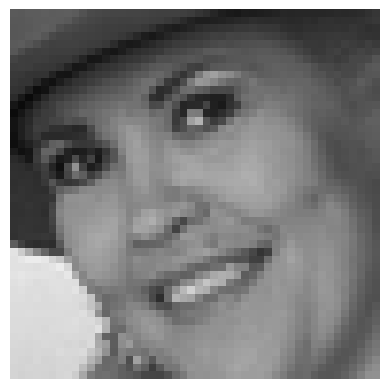

In [8]:
eval_data(data_dir, folder='train', sample_number=1)

### Distribution of classes

In [9]:
from collections import Counter

def show_distribution(dataset):

    sns.set(style="whitegrid")
    
    labels = dataset.labels
    class_counts = Counter(labels)
    
    plt.figure(figsize=(12, 7))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=sns.color_palette("viridis", len(class_counts)), edgecolor='black')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)
    
    
    plt.xlabel('Class Labels', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.title(f'Class Distribution in Dataset', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


For Train dataset: 


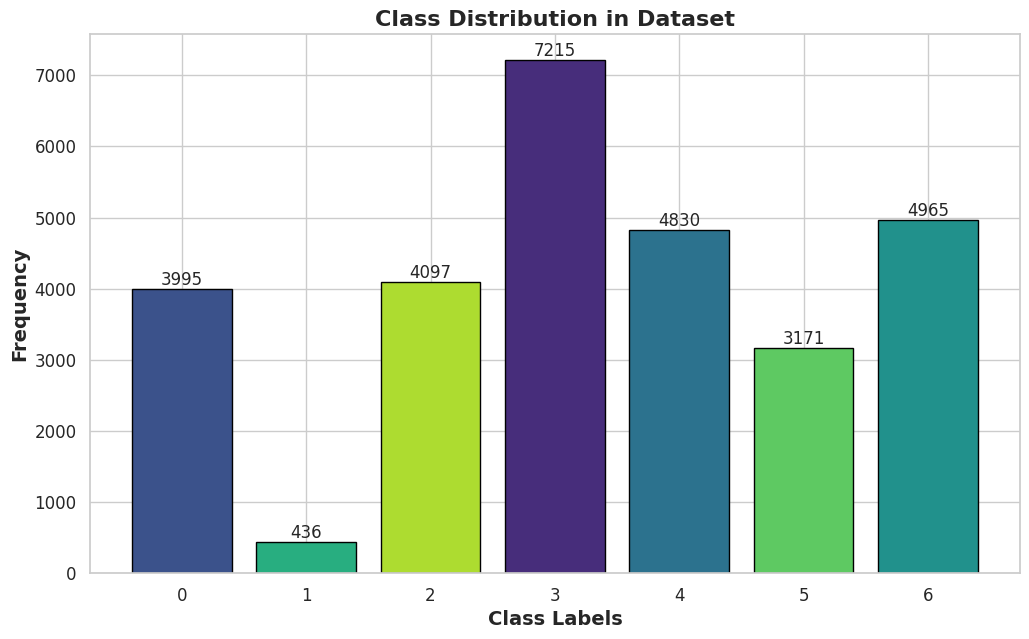

In [10]:
print("For Train dataset: ")
show_distribution(train_dataset)

### Generate data

In [11]:
def augment_small_classes(dataset, target_classes, target_size, augmentation_transform):
    augmented_images = []
    augmented_labels = []

    for class_label in target_classes:
        class_indices = [i for i, label in enumerate(dataset.labels) if label == class_label]
        
        while len(class_indices) < target_size:
            idx = random.choice(class_indices)
            image, label = dataset[idx]
            
            augmented_image = augmentation_transform(image)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)
            

            class_indices.append(idx)

    return augmented_images, augmented_labels

In [12]:
target_classes = [0, 1, 2, 4, 5, 6]  
target_size = 7000

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.0)),
    transforms.ToTensor()
])


augmented_images, augmented_labels = augment_small_classes(train_dataset, target_classes, target_size, augmentation_transform)

In [13]:
augmented_images_pil = [transforms.ToPILImage()(img) for img in augmented_images]

all_images = train_dataset.image_paths + augmented_images_pil
all_labels = list(train_dataset.labels) + augmented_labels

train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

train_aug_dataset = ImageDataset(data_dir=None, folder=None, images=all_images, labels=all_labels, transform=train_transforms)

In [14]:
# all_images = train_dataset.image_paths + [transforms.ToPILImage()(img) for img in augmented_images]
# all_labels = list(train_dataset.labels) + augmented_labels

# train_aug_dataset = ImageDataset(data_dir=None, folder=None, images=all_images, labels=all_labels, transform=train_dataset.transform)


For Train dataset with augmentation: 


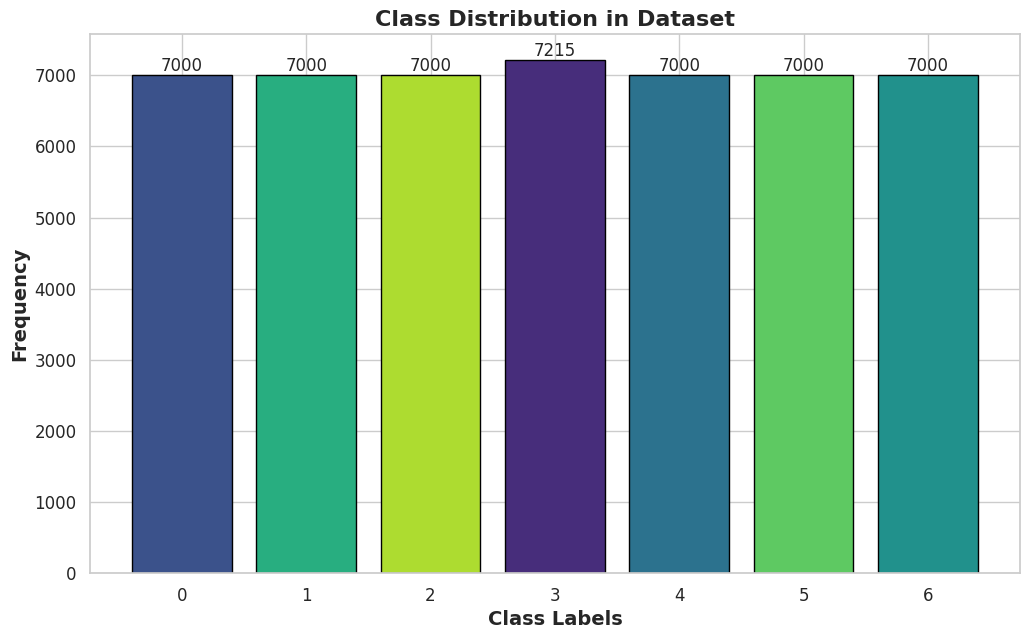

In [15]:
print("For Train dataset with augmentation: ")
show_distribution(train_aug_dataset)

## Classificators

### VGG-19

In [16]:
BATCH_SIZE = 32
NUM_EPOCHS = 15

In [17]:
train_loader = DataLoader(train_aug_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
print(torch.cuda.is_available())

True


In [19]:
vgg_19 = vgg19(weights=VGG19_Weights.DEFAULT)

for param in vgg_19.parameters():
    param.requires_grad = False

In [20]:
num_classes = len(set(train_aug_dataset.labels))

vgg_19.classifier[6] = nn.Linear(4096, num_classes)
vgg_19 = vgg_19.to('cuda' if torch.cuda.is_available() else 'cpu')

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_19.classifier[6].parameters(), lr=0.001)

In [ ]:
# def train(model, train_loader, criterion, optimizer, epoch):
#     model.train()
#     running_loss = 0.0

#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch"):
#         images, labels = images.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     avg_loss = running_loss / len(train_loader)
#     print(f"Training loss: {avg_loss:.4f}")

In [21]:
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_loss_list = []
    train_acc_list = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        train_loss_list.append(avg_loss)
        train_acc_list.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_loss_list, train_acc_list

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss, train_accuracy = train(vgg_19, train_loader, loss_func, optimizer, NUM_EPOCHS, device)

Epoch 1/15: 100%|█████████████████████████████████████████| 1538/1538 [32:11<00:00,  1.26s/batch]


Epoch [1/15], Loss: 1.8743, Accuracy: 27.64%


Epoch 2/15: 100%|████████████████████████| 1538/1538 [30:50<00:00,  1.20s/batch]


Epoch [2/15], Loss: 1.8940, Accuracy: 28.21%


Epoch 3/15:  70%|████████████████▋       | 1071/1538 [21:25<09:20,  1.20s/batch]

In [64]:
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.show()

NameError: name 'с' is not defined